In [ ]:
from google.colab import files
uploaded = files.upload()

Saving taxi_fare.csv to taxi_fare.csv


In [ ]:
# Import libraries
import pandas as pd
import numpy as np

# Load uploaded dataset
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# -------------------------
# 1️⃣ Data Cleaning
# -------------------------

#Remove invalid trips
df = df[df['fare_amount'] > 0]
df = df[df['total_amount'] > 0]
df = df[df['passenger_count'] > 0]

# Remove invalid coordinates
df = df[(df['pickup_longitude'].between(-180, 180)) & (df['pickup_latitude'].between(-90, 90))]
df = df[(df['dropoff_longitude'].between(-180, 180)) & (df['dropoff_latitude'].between(-90, 90))]

# Remove duplicates
df = df.drop_duplicates()

# -------------------------
# 2️⃣ Datetime Conversion
# -------------------------
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Convert from UTC to EDT (UTC-4)
df['pickup_datetime_EDT'] = df['tpep_pickup_datetime'] - pd.Timedelta(hours=4)

# -------------------------
# 3️⃣ Feature Engineering
# -------------------------

df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

df['pickup_day'] = df['pickup_datetime_EDT'].dt.dayofweek
df['is_weekend'] = df['pickup_day'].apply(lambda x: 1 if x >= 5 else 0)

df['pickup_hour'] = df['pickup_datetime_EDT'].dt.hour
df['am_pm'] = df['pickup_hour'].apply(lambda x: 'AM' if x < 12 else 'PM')
df['is_night'] = df['pickup_hour'].apply(lambda x: 1 if (x >= 22 or x < 6) else 0)

# Rush hour flag (7–10 AM, 4–7 PM)
df['is_rush_hour'] = df['pickup_hour'].apply(lambda x: 1 if (7 <= x <= 10 or 16 <= x <= 19) else 0)

# Encode store_and_fwd_flag (N->0, Y->1)
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

# -------------------------
# Trip Distance (Haversine Formula)
# -------------------------
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in km
    return c * r

df['trip_distance_km'] = haversine(df['pickup_longitude'], df['pickup_latitude'],
                                   df['dropoff_longitude'], df['dropoff_latitude'])

# Average speed km/min
df['avg_speed_km_min'] = df['trip_distance_km'] / df['trip_duration_min']

# Fare per km
df['fare_per_km'] = df['fare_amount'] / df['trip_distance_km']

# -------------------------
# Final Cleanup
# -------------------------
# Remove trips with zero or negative trip_distance or duration (if any)
df = df[(df['trip_distance_km'] > 0) & (df['trip_duration_min'] > 0)]

df = df.reset_index(drop=True)

df.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,...,trip_duration_min,pickup_day,is_weekend,pickup_hour,am_pm,is_night,is_rush_hour,trip_distance_km,avg_speed_km_min,fare_per_km
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,-73.976746,40.765152,1,0,-74.004265,40.746128,...,7.916667,0,0,20,PM,0,0,3.138096,0.396391,2.867981
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,-73.983482,40.767925,1,0,-74.005943,40.733166,...,11.100000,0,0,20,PM,0,0,4.303331,0.387687,2.556159
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,-73.782021,40.644810,1,0,-73.974541,40.675770,...,31.100000,0,0,20,PM,0,0,16.600142,0.533767,3.283104
3,1,2016-03-01 00:00:01,2016-03-01 00:16:04,1,-73.788773,40.647758,1,0,-73.829208,40.712345,...,16.050000,0,0,20,PM,0,0,7.950066,0.495331,2.578595
4,1,2016-03-01 00:00:01,2016-03-01 00:05:00,1,-73.958221,40.764641,1,0,-73.967896,40.762901,...,4.983333,0,0,20,PM,0,0,0.837394,0.168039,6.567992


4️⃣ Exploratory Data Analysis (EDA)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


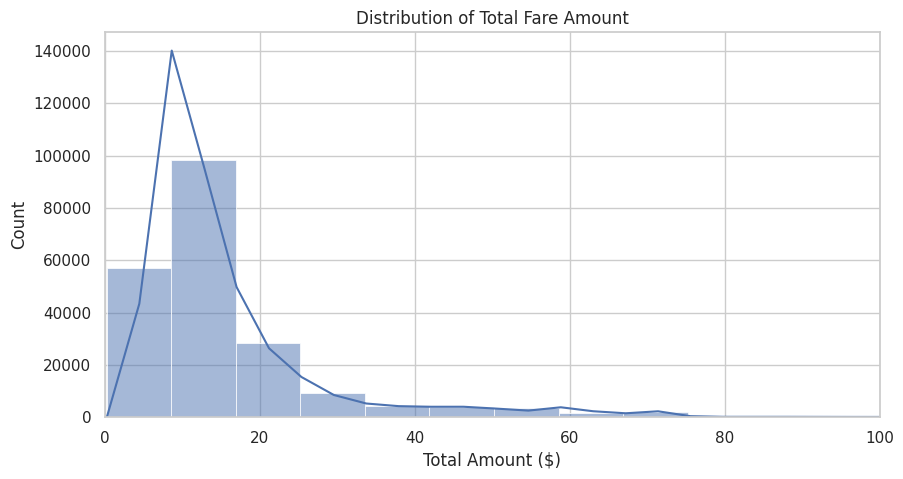

In [ ]:
# -------------------------
# 1️⃣ Univariate Analysis
# -------------------------

#Distribution of Target Variable (total_amount)
plt.figure(figsize=(10,5))
sns.histplot(df['total_amount'], bins=100, kde=True)
plt.title('Distribution of Total Fare Amount')
plt.xlabel('Total Amount ($)')
plt.xlim(0, 100)  # Focus on majority of fares
plt.show()


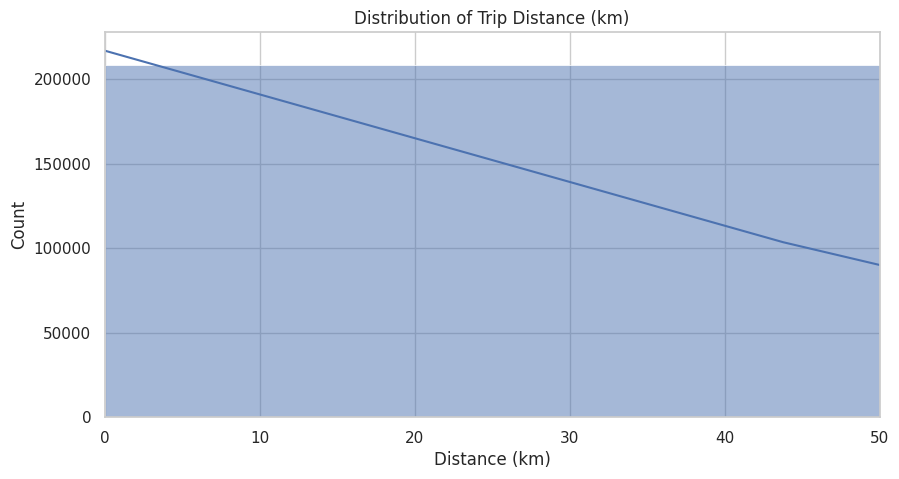

In [ ]:
#Distribution of Trip Distance

plt.figure(figsize=(10,5))
sns.histplot(df['trip_distance_km'], bins=100, kde=True)
plt.title('Distribution of Trip Distance (km)')
plt.xlabel('Distance (km)')
plt.xlim(0, 50)  # Focus on typical trips
plt.show()


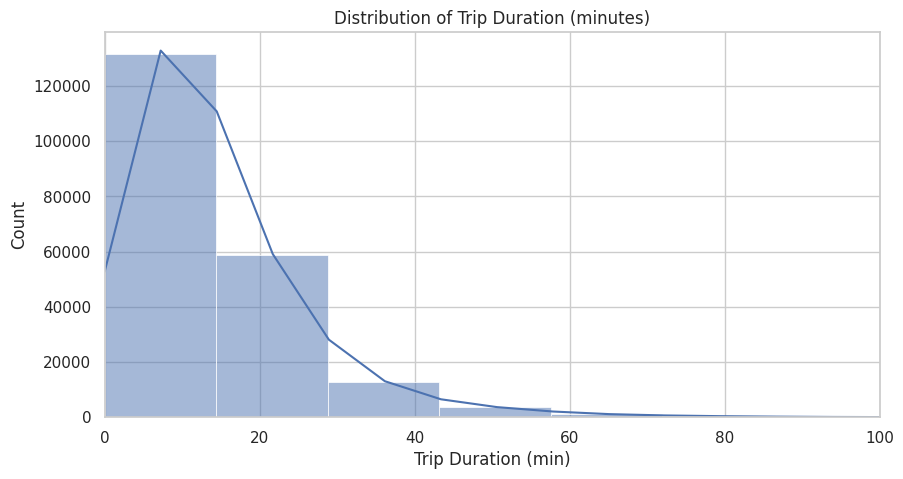

In [ ]:
#Distribution of Trip Duration

plt.figure(figsize=(10,5))
sns.histplot(df['trip_duration_min'], bins=100, kde=True)
plt.title('Distribution of Trip Duration (minutes)')
plt.xlabel('Trip Duration (min)')
plt.xlim(0, 100)  # Focus on typical trips
plt.show()


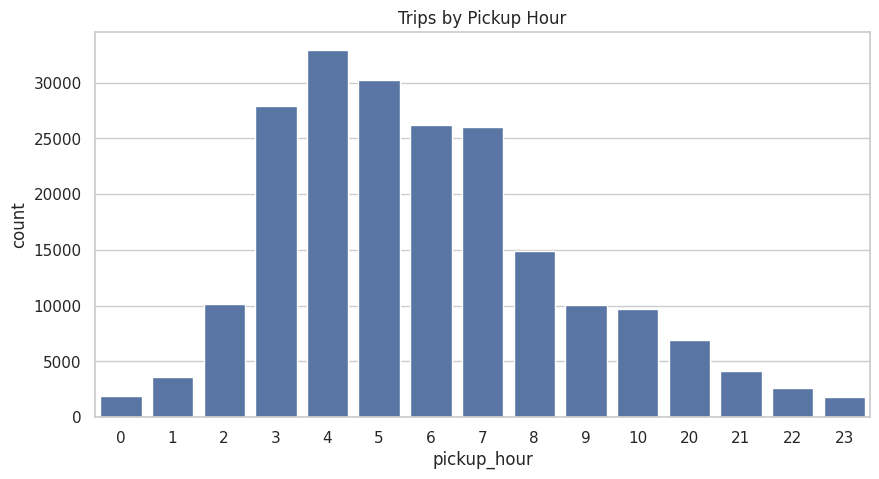

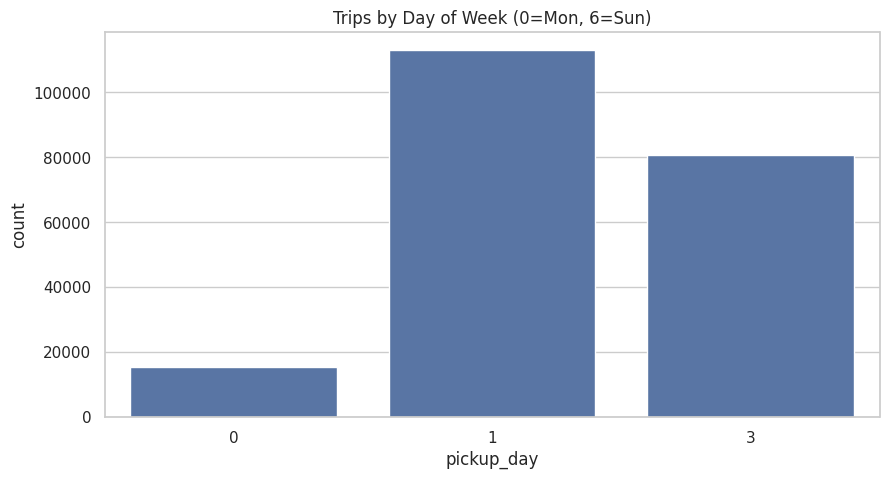

In [ ]:
#Pickup Hour & Day

plt.figure(figsize=(10,5))
sns.countplot(x='pickup_hour', data=df)
plt.title('Trips by Pickup Hour')
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(x='pickup_day', data=df)
plt.title('Trips by Day of Week (0=Mon, 6=Sun)')
plt.show()


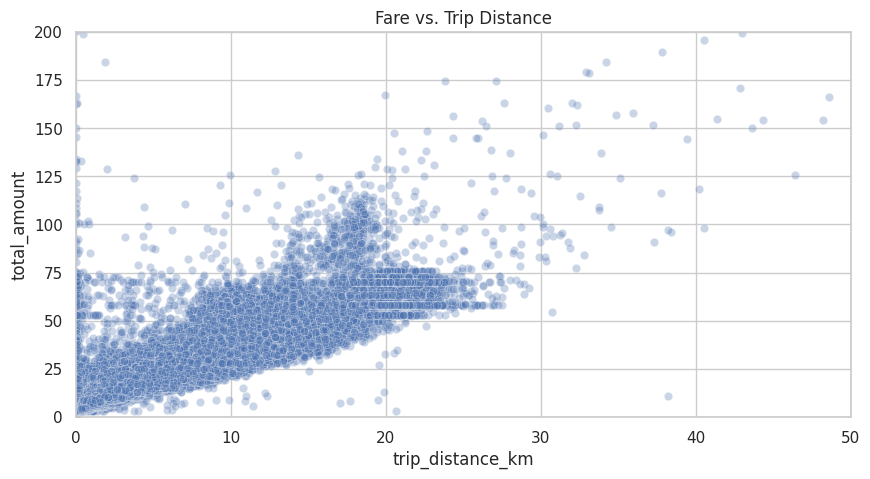

In [ ]:
# -------------------------
# 2️⃣ Bivariate Analysis
# -------------------------

#Fare vs. Trip Distance

plt.figure(figsize=(10,5))
sns.scatterplot(x='trip_distance_km', y='total_amount', data=df, alpha=0.3)
plt.title('Fare vs. Trip Distance')
plt.xlim(0, 50)
plt.ylim(0, 200)
plt.show()


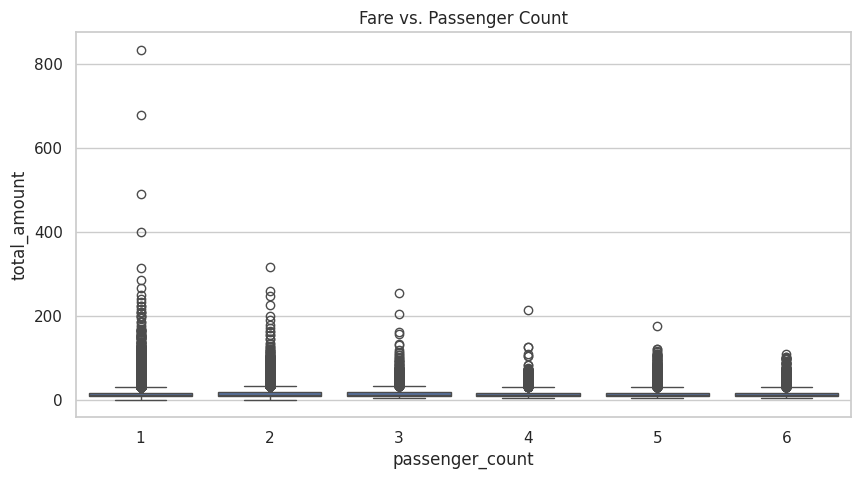

In [ ]:
#Fare vs. Passenger Count

plt.figure(figsize=(10,5))
sns.boxplot(x='passenger_count', y='total_amount', data=df)
plt.title('Fare vs. Passenger Count')
plt.show()


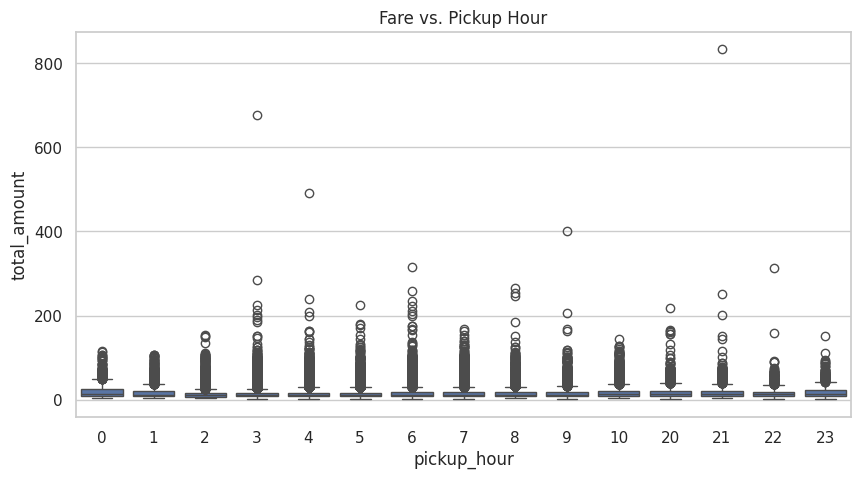

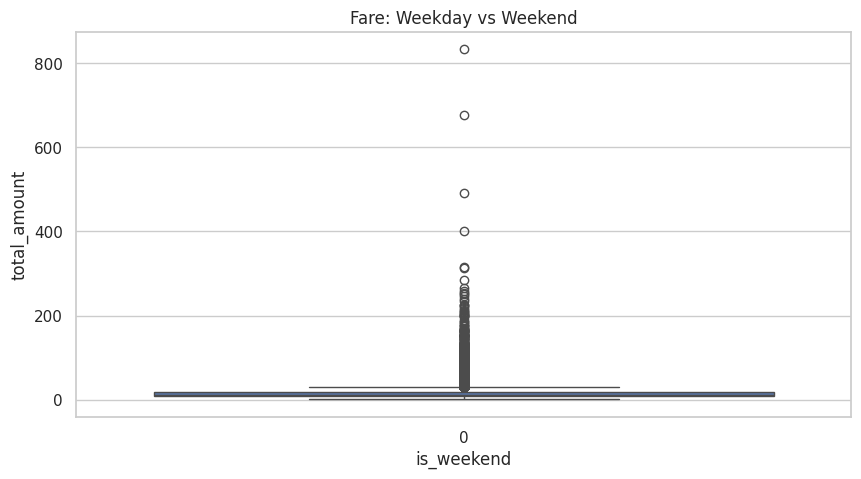

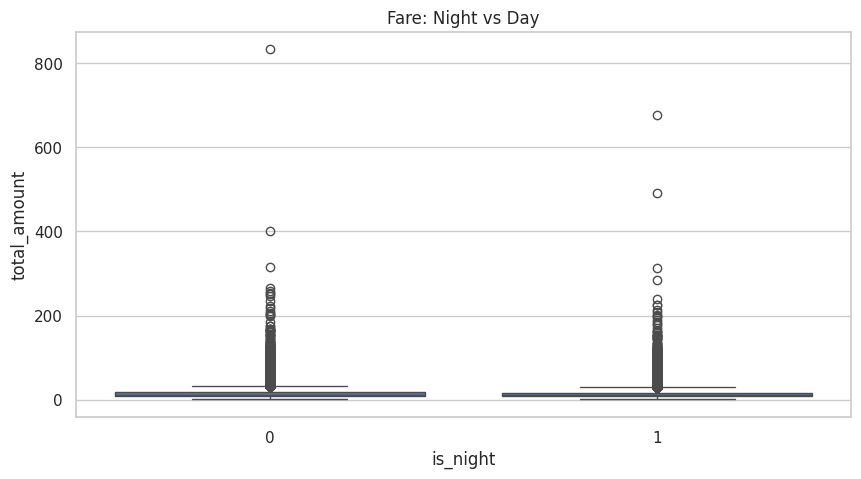

In [ ]:
#Fare vs. Time Features

plt.figure(figsize=(10,5))
sns.boxplot(x='pickup_hour', y='total_amount', data=df)
plt.title('Fare vs. Pickup Hour')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='is_weekend', y='total_amount', data=df)
plt.title('Fare: Weekday vs Weekend')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='is_night', y='total_amount', data=df)
plt.title('Fare: Night vs Day')
plt.show()


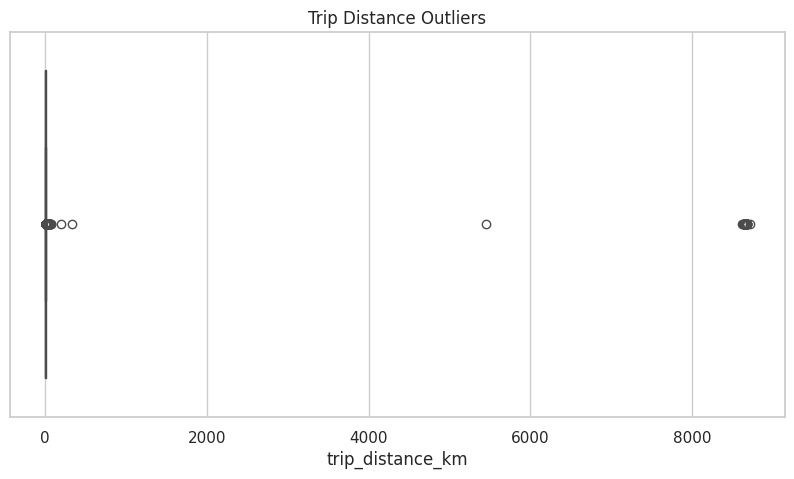

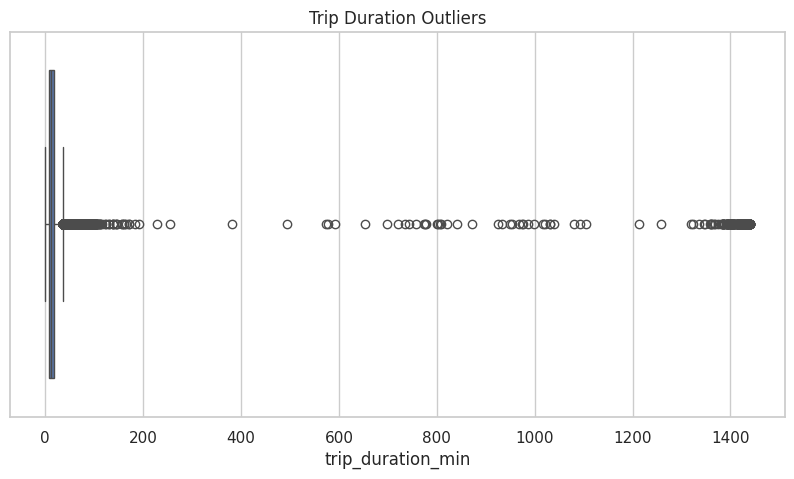

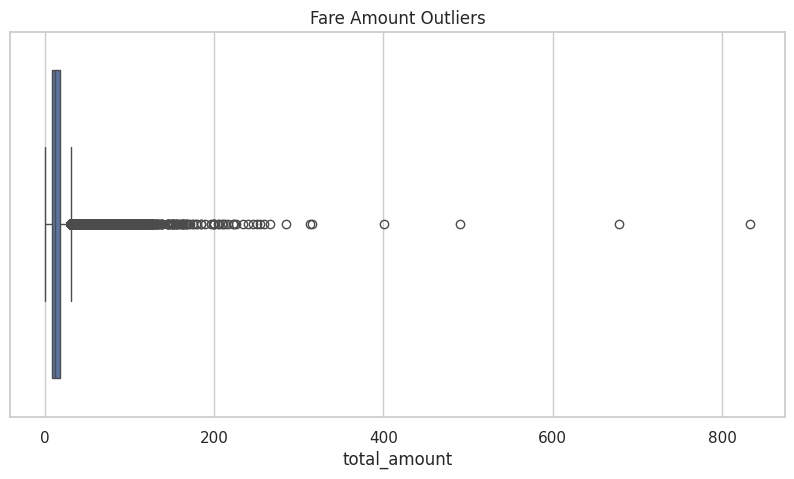

In [ ]:
# -------------------------
# 3️⃣ Outlier Detection
# -------------------------

#Visualize Outliers

plt.figure(figsize=(10,5))
sns.boxplot(x=df['trip_distance_km'])
plt.title('Trip Distance Outliers')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x=df['trip_duration_min'])
plt.title('Trip Duration Outliers')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x=df['total_amount'])
plt.title('Fare Amount Outliers')
plt.show()


In [ ]:
#Remove Extreme Outliers

df = df[df['total_amount'] < 200]
df = df[df['trip_distance_km'] < 50]
df = df[df['trip_duration_min'] < 100]


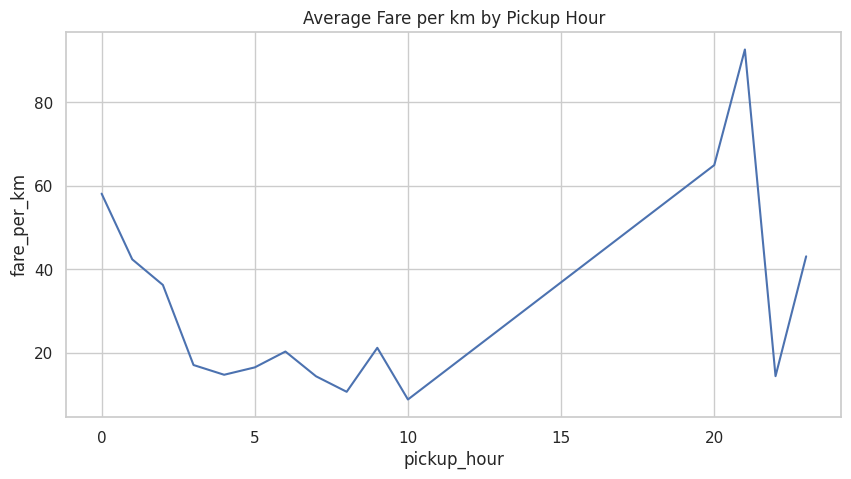

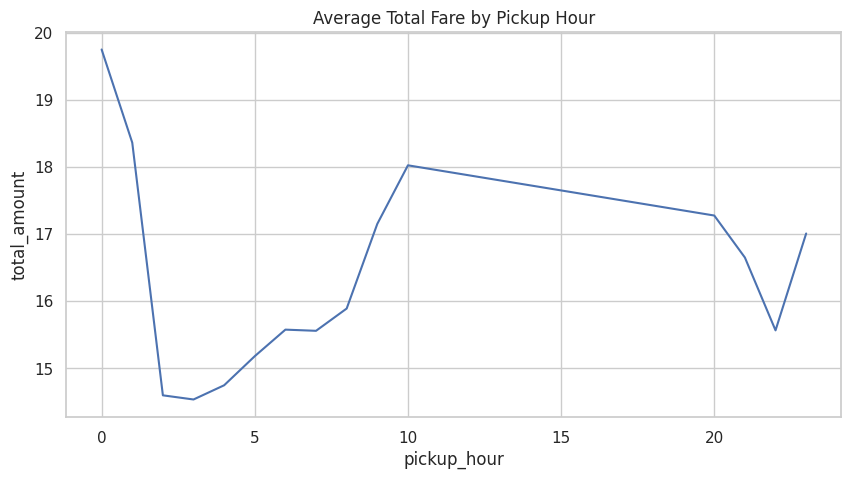

In [ ]:
# -------------------------------
# 4️⃣ Additional Pattern Analysis
# -------------------------------

#Fare per km & Fare per minute by Pickup Hour

plt.figure(figsize=(10,5))
sns.lineplot(x='pickup_hour', y='fare_per_km', data=df.groupby('pickup_hour').fare_per_km.mean().reset_index())
plt.title('Average Fare per km by Pickup Hour')
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(x='pickup_hour', y='total_amount', data=df.groupby('pickup_hour').total_amount.mean().reset_index())
plt.title('Average Total Fare by Pickup Hour')
plt.show()

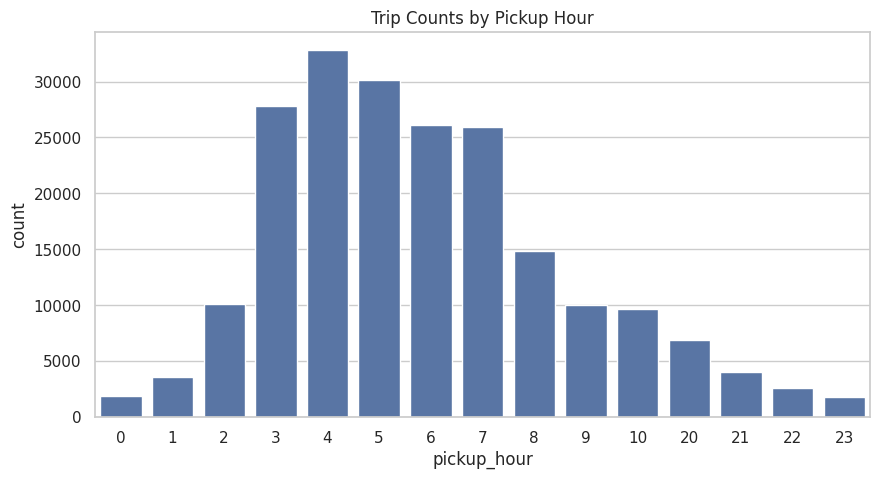

In [ ]:
#Trip Counts by Pickup Hour

plt.figure(figsize=(10,5))
trip_counts_by_hour = df.groupby('pickup_hour').size().reset_index(name='count')
sns.barplot(x='pickup_hour', y='count', data=trip_counts_by_hour)
plt.title('Trip Counts by Pickup Hour')
plt.show()

5️⃣ Data Transformation

In [ ]:
# ------------------------------------
# 1️⃣ Handle Outliers Using IQR Method
# ------------------------------------

# Select continuous features to check for outliers
cont_cols = ['trip_distance_km', 'trip_duration_min', 'fare_amount', 'total_amount', 'tip_amount', 'fare_per_km']

for col in cont_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]


In [ ]:
# -------------------------------------------
# 2️⃣ Handle Skewness in Continuous Variables
# -------------------------------------------

df[cont_cols].skew()


,0
trip_distance_km,1.257248
trip_duration_min,0.722125
fare_amount,0.707943
total_amount,0.681634
tip_amount,0.493469
fare_per_km,0.652330


In [ ]:
#Apply Transformations

import numpy as np

df['trip_distance_km_log'] = np.log1p(df['trip_distance_km'])
df['trip_duration_min_log'] = np.log1p(df['trip_duration_min'])
df['fare_amount_log'] = np.log1p(df['fare_amount'])
df['total_amount_log'] = np.log1p(df['total_amount'])
df['fare_per_km_log'] = np.log1p(df['fare_per_km'])


In [ ]:
# --------------------------------
# 3️⃣ Encode Categorical Variables
# --------------------------------

df = pd.get_dummies(df, columns=['am_pm'], drop_first=True)

df = pd.get_dummies(df, columns=['RatecodeID', 'payment_type'], drop_first=True)


In [ ]:
# -----------------
# 4️⃣ Final Cleanup
# -----------------

df = df.drop(['trip_distance_km', 'trip_duration_min', 'fare_amount', 'fare_per_km'], axis=1)


In [ ]:
df = df.reset_index(drop=True)


6️⃣ Feature Selection

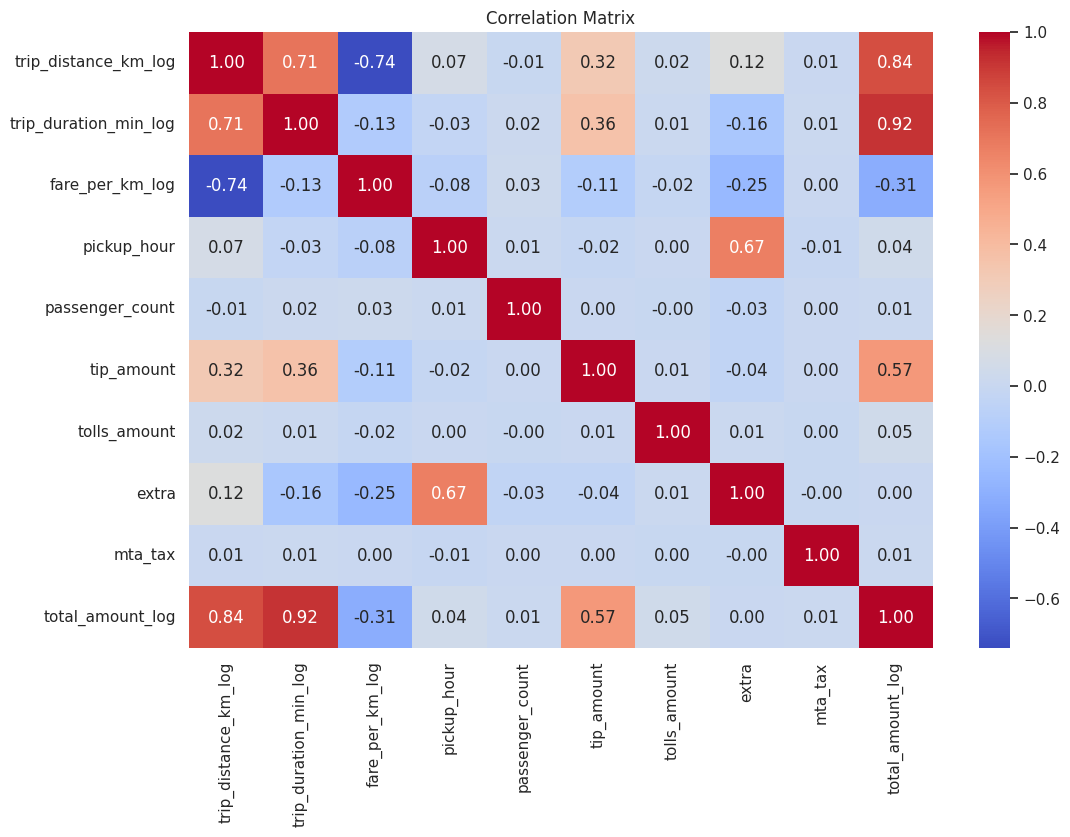

In [ ]:
# -------------------------------------------------
# 1️⃣ Correlation Analysis (for numerical features)
# -------------------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric features
numeric_features = ['trip_distance_km_log', 'trip_duration_min_log',
                    'fare_per_km_log', 'pickup_hour', 'passenger_count',
                    'tip_amount', 'tolls_amount', 'extra', 'mta_tax']

# Correlation matrix
corr = df[numeric_features + ['total_amount_log']].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# ----------------------------------------------
# 2️⃣ Chi-Square Test (for Categorical Features)
# ----------------------------------------------

from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer

# Discretize target variable
kb = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
y_binned = kb.fit_transform(df[['total_amount_log']])

# Encode categorical features
cat_features = ['store_and_fwd_flag', 'am_pm_PM', 'is_weekend', 'is_night', 'is_rush_hour']
X_cat = df[cat_features]

chi_scores, p_values = chi2(X_cat, y_binned)
chi_results = pd.DataFrame({'Feature': cat_features, 'Chi2 Score': chi_scores, 'p-value': p_values})
chi_results.sort_values(by='Chi2 Score', ascending=False)


,Feature,Chi2 Score,p-value
3,is_night,172.231966,2.114731e-32
4,is_rush_hour,158.150646,1.798559e-29
1,am_pm_PM,107.618133,4.487477e-19
0,store_and_fwd_flag,13.621844,1.364271e-01
2,is_weekend,NaN,NaN


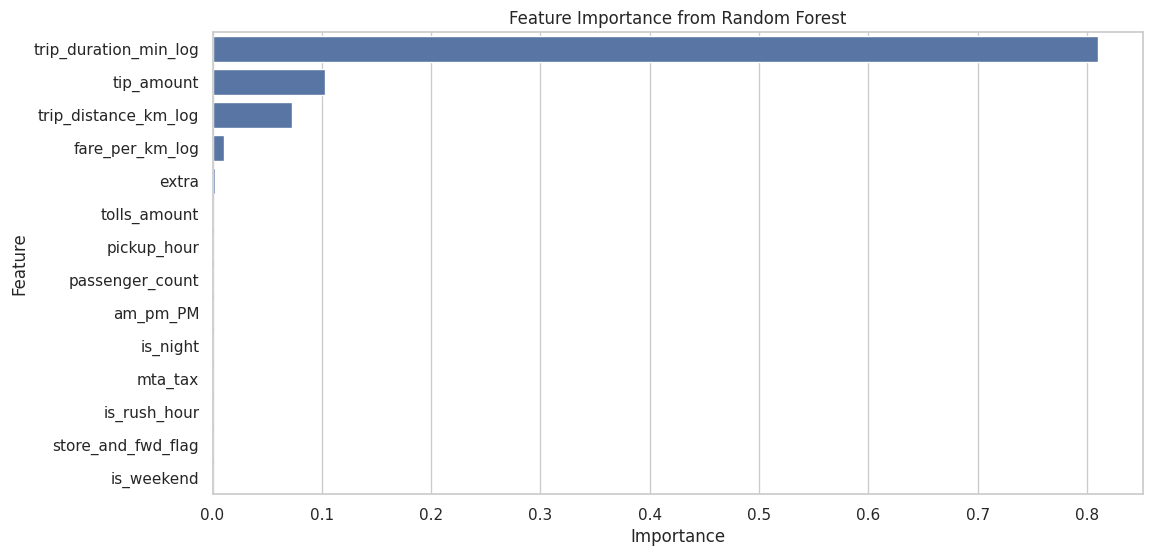

In [ ]:
# ------------------------------------------
# 3️⃣ Feature Importance Using Random Forest
# ------------------------------------------

from sklearn.ensemble import RandomForestRegressor

# Prepare dataset
X = df[numeric_features + cat_features]
y = df['total_amount_log']

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature importance
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title("Feature Importance from Random Forest")
plt.show()


7️⃣ Model Building & Evaluation

In [ ]:
# --------------------------------
# 1️⃣ Prepare Features and Target
# --------------------------------

from sklearn.model_selection import train_test_split

# Features: select top features after feature selection
features = ['trip_distance_km_log', 'trip_duration_min_log', 'fare_per_km_log',
            'pickup_hour', 'passenger_count', 'tip_amount', 'tolls_amount',
            'extra', 'mta_tax', 'store_and_fwd_flag', 'am_pm_PM',
            'is_weekend', 'is_night', 'is_rush_hour']

X = df[features]
y = df['total_amount_log']  # log-transformed target

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# ---------------------------
# 2️⃣ Import Models & Metrics
# ---------------------------

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
# ------------------
# 3️⃣ Define Models
# ------------------

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}


In [ ]:
# ---------------------------
# 4️⃣ Train Models & Evaluate
# ---------------------------
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse) # Calculate RMSE by taking the square root of MSE
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    })

results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False)
results_df

,Model,R²,MSE,RMSE,MAE
3,Random Forest,0.997156,0.000351,0.018741,0.006612
4,Gradient Boosting,0.986404,0.001679,0.040979,0.029074
1,Ridge Regression,0.985719,0.001764,0.041999,0.030974
0,Linear Regression,0.985711,0.001765,0.042011,0.030979
2,Lasso Regression,0.963978,0.004449,0.066703,0.047724


In [ ]:
# --------------------------
# 5️⃣ Hyperparameter Tuning
# --------------------------

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Defining the model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Keep parameter grid small & efficient
param_dist = {
    'n_estimators': [100, 150],        # fewer trees to save time
    'max_depth': [10, 20, None],       # limit depth
    'min_samples_split': [2, 5, 10],   # reasonable splits
    'min_samples_leaf': [1, 2, 4],     # small leaf options
    'max_features': ['sqrt']           # best for RF
}

# Randomized Search (lightweight)
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,          # only 5 combos → FAST
    cv=2,              # fewer folds
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Train on a smaller sample for tuning
X_sample = X_train.sample(frac=0.3, random_state=42)
y_sample = y_train.loc[X_sample.index]

rf_random.fit(X_sample, y_sample)

print("Best Params:", rf_random.best_params_)
print("Best Score:", rf_random.best_score_)

# Retrain final model on FULL dataset with best params
best_rf = RandomForestRegressor(
    **rf_random.best_params_,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Params: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best Score: 0.9900680106233053


RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=150,
                      n_jobs=-1, random_state=42)

In [ ]:
#Evaluate & Compare Models

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    }

# Initialize models
linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.01)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)


# Dictionary of models
models = {
    "Linear Regression": linear_model,
    "Ridge": ridge_model,
    "Lasso": lasso_model,
    "Random Forest": best_rf,   # Your tuned RF
    "Gradient Boosting": gb_model
}

# Evaluate all
results = {}
for name, model in models.items():    # Train the model before evaluating
    model.fit(X_train, y_train)
    results[name] = evaluate_model(model, X_train, y_train, X_test, y_test)

# Creating DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                         R2       MAE      RMSE
Linear Regression  0.985711  0.030979  0.042011
Ridge              0.985719  0.030974  0.041999
Lasso              0.963978  0.047724  0.066703
Random Forest      0.994856  0.015205  0.025206
Gradient Boosting  0.986404  0.029074  0.040979


8⃣ Finalize Best Models

In [ ]:
import pickle

# Save the best model (Random Forest)
best_model = best_rf
with open("best_rf_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("✅ Model saved as best_rf_model.pkl")

# -------------------------
# Load the model later (for prediction)
with open("best_rf_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)


print("Sample Prediction:", loaded_model.predict([X_test.iloc[0]]))

✅ Model saved as best_rf_model.pkl
Sample Prediction: [2.279275]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
from google.colab import files
files.download("best_rf_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>